In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd
import os

In [3]:
from sklearn.decomposition import PCA
from node import remove_outliers
df, df_codified = read_banking_data()

pca = PCA(n_components=3)
reduced = pca.fit_transform(df_codified.loc[:,df_codified.columns!="y"])
df_reduced = pd.DataFrame(data = reduced, columns = ["x", "y", "z"])
df_reduced["label"] = df.y
df_reduced["pi"] = "pi0"

suffled_df = df_reduced.sample(frac=1)
no_nodes = 8
sample_size =  int(df_reduced.shape[0]/no_nodes)

raw_node_data= []
for i in range(no_nodes):
    node_df = suffled_df.iloc[i*sample_size:(i+1) * sample_size].copy()
    node = "pi" + str(i+1)
    node_df.loc[:,"pi"] = node
    raw_node_data.append(node_df)
node_data, models = remove_outliers(raw_node_data, return_models=True)

In [4]:
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced"])
pd.concat(raw_node_data).reset_index(drop=True).to_csv(directory + "//raw_node_data.csv")
pd.concat(node_data).reset_index(drop=True).to_csv(directory + "//node_data.csv"

In [9]:
from node import get_node_data
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced", "node_data.csv"])
data = pd.read_csv(directory, header =0, index_col = 0)
node_data = get_node_data(data, experiment =False)

In [5]:
def pca_experiment(df):
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_[:3]))
    print(sum(pca.explained_variance_ratio_[:2]))

In [6]:
pca_experiment(df_codified.loc[:,df.columns!="y"])

[6.26788004e-01 3.30833615e-01 4.08471400e-02 1.01374092e-03
 1.92314271e-04 1.20238712e-04 6.96673197e-05 4.96416195e-05
 3.82617908e-05 1.80198272e-05 9.08848239e-06 7.24184225e-06
 4.84543109e-06 2.87288460e-06 1.92717561e-06 1.42287924e-06
 1.31112996e-06 2.47969899e-07 2.17159931e-07 1.81502791e-07]
0.998468759079651
0.9576216190451263


In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_per_label(df):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    yes = df.loc[df.label == "yes"]
    no = df.loc[df.label == "no"]
    ax.scatter3D(yes.x, yes.y, yes.z, alpha=0.5, label = "yes")
    ax.scatter3D(no.x, no.y, no.z, alpha=0.5, label = "no")
    plt.legend()
    plt.show()

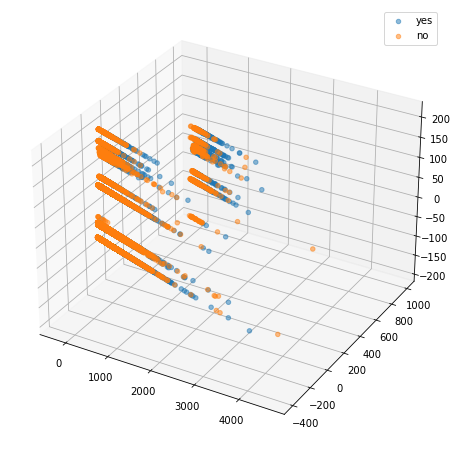

In [8]:
plot_per_label(df_reduced)

In [15]:
def plot_samples(node_data, per_label=False):
    if not per_label:
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
    for df in node_data:
        if per_label:
            print(df.pi.values[0])
            plot_per_label(df)
        else:
            ax.scatter3D(df.x, df.y, df.z, alpha =0.3)
    if not per_label:
        plt.show()

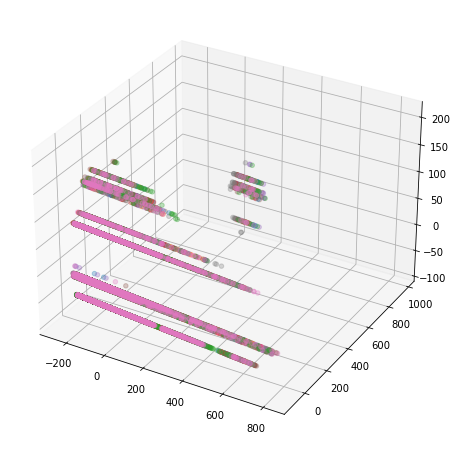

In [10]:
plot_samples(raw_node_data)

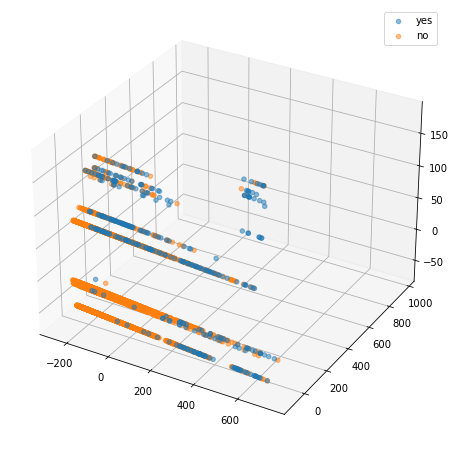

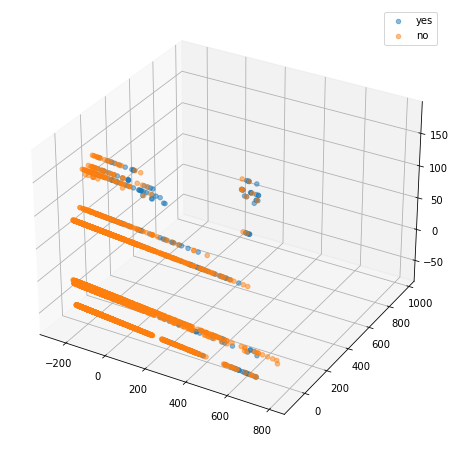

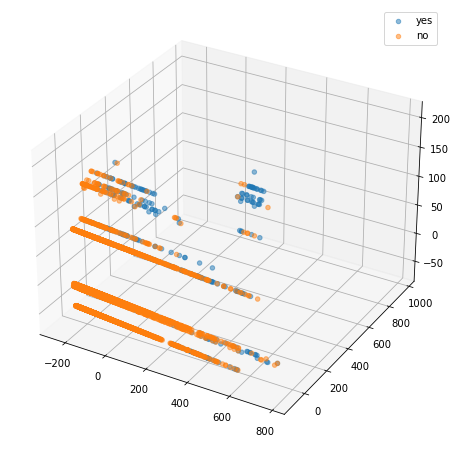

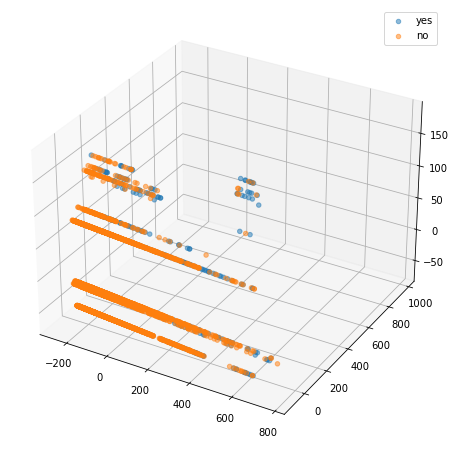

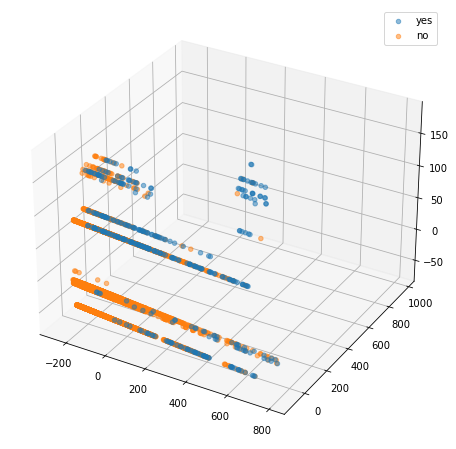

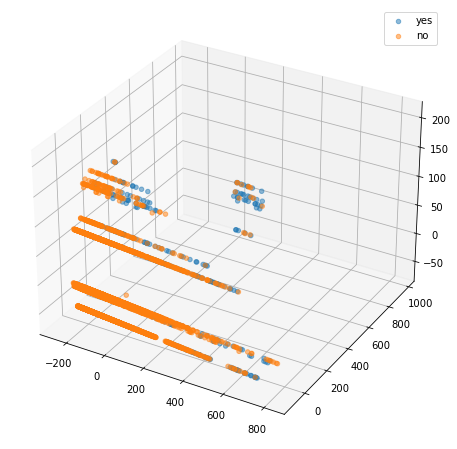

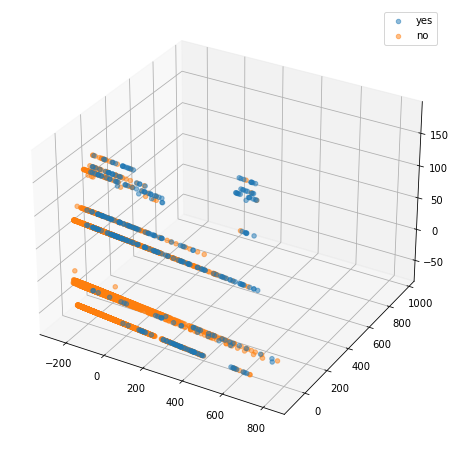

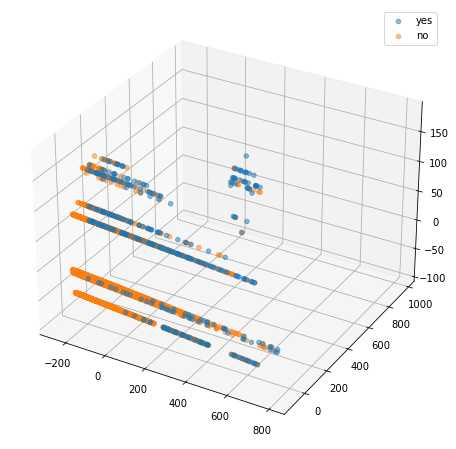

In [11]:
plot_samples(raw_node_data, per_label=True)

pi1


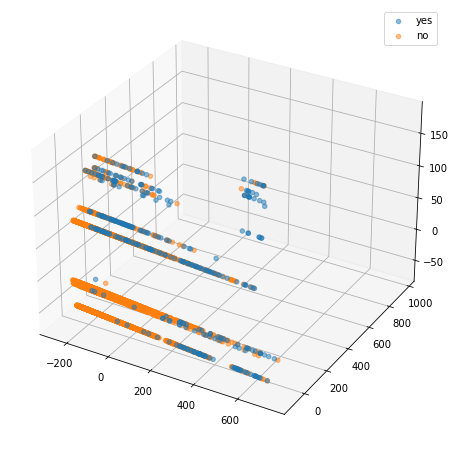

pi2


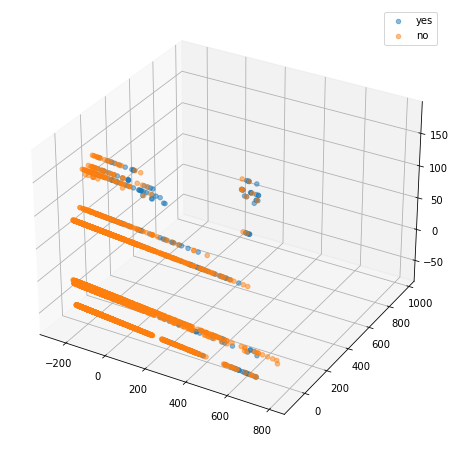

pi3


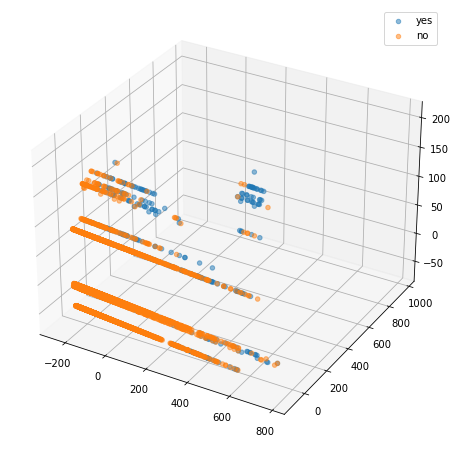

pi4


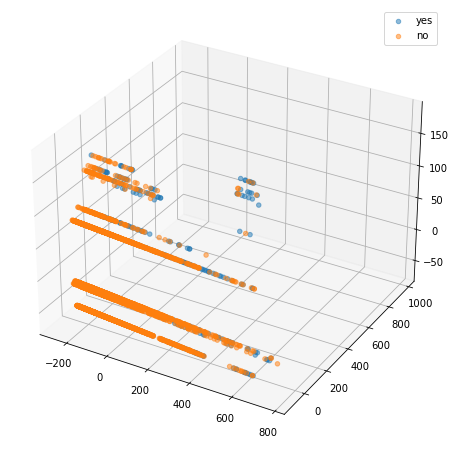

pi5


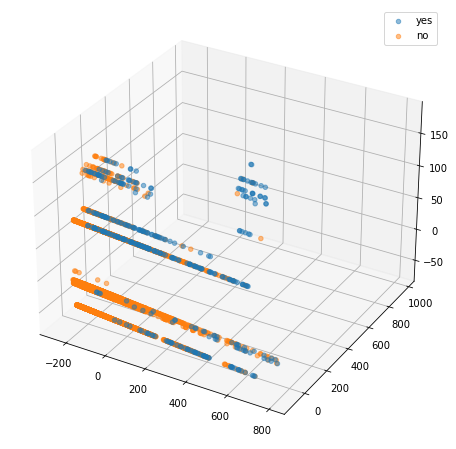

pi6


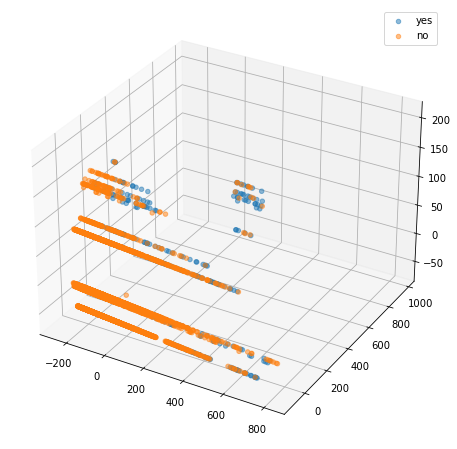

pi7


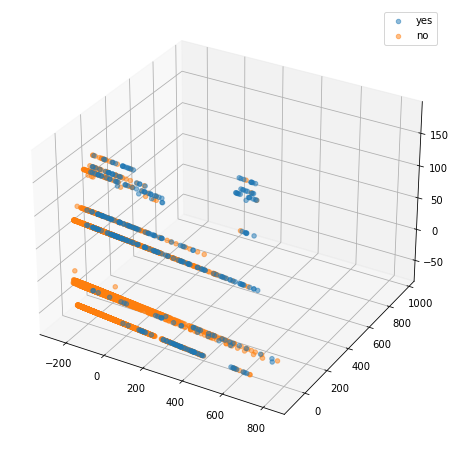

pi8


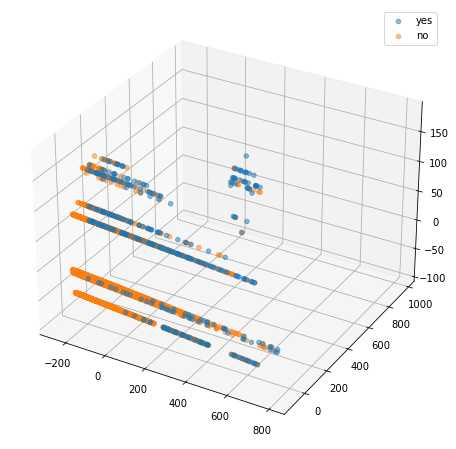

In [16]:
plot_samples(node_data, per_label=True)

In [17]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

In [18]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_sample_size = min([df.shape[0] for df in node_data])
tensor_samples = get_tensor_samples(node_data, sample_size=tensor_sample_size)

In [28]:
import numpy as np
similar_nodes = ["pi5", "pi6"]
other_nodes = ["pi1", "pi2","pi3","pi4","pi7", "pi8"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.5, 2, 4), "linear")

LINEAR 

+----------------+------------------+
|     Nodes      |   Similar MMD    |
+----------------+------------------+
| ('pi5', 'pi6') | 1.33514404296875 |
| ('pi1', 'pi2') | 1.3267822265625  |
+----------------+------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi1', 'pi5') |  9.3092041015625  |
| ('pi1', 'pi6') | 13.21612548828125 |
| ('pi2', 'pi5') |  8.4071044921875  |
| ('pi2', 'pi6') | 12.55169677734375 |
| ('pi3', 'pi5') |   12.4228515625   |
| ('pi3', 'pi6') | 13.03277587890625 |
| ('pi4', 'pi5') |  37.334228515625  |
| ('pi4', 'pi6') | 44.64385986328125 |
| ('pi7', 'pi5') |  3.32110595703125 |
| ('pi7', 'pi6') |  6.7484130859375  |
| ('pi8', 'pi5') |  4.7926025390625  |
| ('pi8', 'pi6') |  3.71380615234375 |
| ('pi1', 'pi3') |   5.615966796875  |
| ('pi1', 'pi4') |  11.1627197265625 |
| ('pi1', 'pi7') |  6.20477294921875 |
| ('pi1', 'pi8') |    8.3759765625   |
| ('pi2', 'pi3') |  5.

In [29]:
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1000, 10000, 5), "rbf")

RBF 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi5', 'pi6') | 0.0005776062607765198  |
| ('pi1', 'pi5') |  0.000491313636302948  |
| ('pi1', 'pi6') |  0.000471651554107666  |
| ('pi2', 'pi5') | 0.0004221722483634949  |
| ('pi2', 'pi6') | 0.00042957067489624023 |
| ('pi4', 'pi5') | 0.0004580840468406677  |
| ('pi8', 'pi5') | 0.00041329115629196167 |
| ('pi8', 'pi6') | 0.00043423473834991455 |
| ('pi1', 'pi2') | 0.0003639310598373413  |
| ('pi1', 'pi4') | 0.00029765069484710693 |
| ('pi1', 'pi7') | 0.00044263899326324463 |
| ('pi1', 'pi8') | 0.00029096007347106934 |
| ('pi2', 'pi4') | 0.0003425776958465576  |
| ('pi2', 'pi8') | 0.00043135881423950195 |
| ('pi4', 'pi7') | 0.00038464367389678955 |
| ('pi4', 'pi8') | 0.00032699108123779297 |
| ('pi7', 'pi8') | 0.0002853125333786011  |
+----------------+------------------------+
+----------------+-----------------------+
|     Nodes      |     Diss

In [ ]:
"linear", 2
"rbf", 3250

In [37]:
from sklearn.linear_model import LogisticRegression as LR
def fit(df):
    lr = LR().fit(df[["x", "y", "z"]], df["label"])
    score = lr.score(df[["x", "y", "z"]], df["label"])
    print(score)
    return lr

In [38]:
fit(df_reduced)

0.9072545401573274


In [42]:
lr_models = {df.pi.values[0] : fit(df) for df in node_data} 

0.927924039706517
0.9311609840310746
0.9313619684869415
0.9324411828189079
0.9262295081967213
0.927924039706517
0.9313471502590673
0.9279084826246492


In [41]:
similar_nodes = [('pi5', 'pi6'), ('pi1', 'pi2')]
for x,y in similar_nodes:
    
    lr_models[x], lr_models[y]

In [43]:
from modelling import grid_search_models, fit_clf, score_clf, select_model_data  
from similar import get_similar_pairs_nodes

def test_in_pairs(similar_pairs, model_data, models, mmd_scores, ocsvm_scores):
    l = []
    for i in range(len(similar_pairs)):
        node_x, node_y = similar_pairs[i]
        x = model_data[node_x]
        y = model_data[node_y]
        
        model_x = models[node_x]
        ex = fit_clf(model_x, x)
        exy = score_clf(model_x, y)

        model_y = models[node_y]
        ey = fit_clf(model_y, y)
        eyx = score_clf(model_y, x)       
        
        l.append(pd.DataFrame([{"model_node" : node_x, "test_node" : node_y, "discrepancy" : round(abs(ex-exy),2), 
                                "model_r2-d" : exy, "test_r2" : ey, "mmd_score" : mmd_scores[i], "ocsvm_score" : ocsvm_scores[i][0]}]))
        l.append(pd.DataFrame([{"model_node" : node_y, "test_node" : node_x, "discrepancy" : round(abs(ey-eyx),2),
                                "model_r2-d" : eyx, "test_r2" : ex, "mmd_score" : mmd_scores[i], "ocsvm_score" : ocsvm_scores[i][1]}]))
    return pd.concat(l, ignore_index = True)

In [ ]:
select